## Overview

This analysis is based on the attributes of football players released on [FIFA19](https://www.kaggle.com/karangadiya/fifa19)  dataset on Kaggle. The dataset consists of more than 18000 records of player data with around 90 attributes extracted from FIFA database. In this project, we perform data analysis using **Spark packages**.
 

In this analysis, we divide the task into three parts.

- **Part 1**: Exploratory Data Analysis

- **Part 2**: Clustering Analysis, and identify the position profiles of each cluster

- **Part 3**: Classification Analysis, and evaluate the performance of different algorithms using cross validation;

## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [5]:
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [1]:
#only required for jupyter
import os
os.environ["SPARK_HOME"] = "D:/Projects/spark-2.4.0-bin-hadoop2.7"

In [3]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
link_to_data = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
DataSet = wget.download(link_to_data)

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d41e67bfd7955d921f81008af0a1934d09f9758df9a058ece06676e83261c818
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [7]:
# Import the '2020T2Data.csv' as a Spark dataframe and name it as df
spark = SparkSession.builder.appName('FIFA_19').getOrCreate()
# Your Code 
# not including header as data while reading so the header value is made true
df = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

Getting the summary statistics:

In [12]:
df.describe().show()

+-------+------------------+------------+------------------+--------------------+-----------+--------------------+-----------------+-----------------+--------------------+--------------------+------------------+------------------+------------------+--------------+------------------------+------------------+------------------+--------------+---------+---------+--------+------------------+-----------+-------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------

Missing Values:

In [44]:
from pyspark.sql.functions import isnull, when, count, col
null_values_count = df.select([count(when(isnull(cols), cols)).alias(cols) for cols in df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Vo

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 48 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [48]:
# checking the missing values after removing goalkeepers
df_fil = df.filter(df['Position'] != 'GK')
df_fil.select([count(when(isnull(cols), cols)).alias(cols) for cols in df.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Vo

It is seen that no missing values are present for players belonging to positions other than goalkeepers. So, we can proceed to other analysis steps after this.

Checking the statistics (min, mean and max) for Age, Overall:

In [ ]:
from pyspark.sql import functions as F

#Your code for statistics on Age
# storing the minimum age
min_age = df.select(F.min('Age')).collect()
print(min_age)

# storing the maximum age
max_age = df.select(F.max('Age')).collect()
print(max_age)

# storing the mean age
mean_age = df.select(F.mean('Age')).collect()
print(mean_age)

[Row(min(Age)=16)]
[Row(max(Age)=45)]
[Row(avg(Age)=25.122205745043114)]


In [ ]:
#Your Code for statistics on Overall

# storing the minimum overall
min_overall = df.select(F.min('Overall')).collect()
print(min_overall)

# storing the maximum overall
max_overall = df.select(F.max('Overall')).collect()
print(max_overall)

# storing the mean overall
mean_overall = df.select(F.mean('Overall')).collect()
print(mean_overall)

[Row(min(Overall)=46)]
[Row(max(Overall)=94)]
[Row(avg(Overall)=66.23869940132916)]


Finding the position having highest average overall:

In [ ]:
#Your Code for the position having highest Avg Overall
# sorting the data first and grouping later by Position and showing the position with highest average Overall
df_overall_position = df.groupby('Position').agg({'Overall':'AVG'})
df_overall_position.orderBy(df_overall_position['avg(Overall)'].desc()).take(1)
#df_overall_position.sort('avg(Overall)',ascending=False).first()

[Row(Position='LF', avg(Overall)=73.86666666666666)]

Finding the top 3 countries with highest Avg Overall:

In [ ]:
#Your Code to output top 3 countries with highest Avg Overall
# sorting the data first and grouping later by Countries and showing the top 3 countries with highest average Overall
df_overall_nationality = df.groupby('Nationality').agg({'Overall':'AVG'})
df_overall_nationality.orderBy(df_overall_nationality['avg(Overall)'].desc()).take(3)


[Row(Nationality='United Arab Emirates', avg(Overall)=77.0),
 Row(Nationality='Central African Rep.', avg(Overall)=73.33333333333333),
 Row(Nationality='Israel', avg(Overall)=72.14285714285714)]

Finding the average potentials on country by position!!!:

In [53]:
#Your code for the results on Avg Potentials on Country by Position with ordering the results on country by alphabet (show top 10)
# creating a pivot table in which the value of column Nationality is transposed to multiple columns 
pivot_df = df.groupBy("Position").pivot("Nationality").avg("Potential")
pivot_df.show(30)

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+--------------------+----+------------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+----

In [69]:
pivot_df = pivot_df.withColumnRenamed('Central African Rep.', 'Central African Republic')

In [79]:
from pyspark.sql.functions import greatest, col, lit, coalesce, sum
#rowmax = sum([coalesce(col(x), lit(0)) for x in pivot_df.columns])
rowmax = greatest(*[coalesce(col(x), lit(0)) for x in pivot_df.drop('Position').columns])
pivot_df.withColumn('Position(Maximum)',rowmax).show(30)
#print(rowmax)

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+------------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+

In [ ]:
rowmax = greatest(*[coalesce(col(x), minf) for x in ['v2','v3','v4']])
df1.withColumn("rowmax", rowmax)
rowsum = sum([coalesce(col(x), lit(0)) for x in ['v2','v3','v4']])

Finding the position with highest average potential for Australia: 

In [56]:
#Your Code to identify the position having highest Avg Potential for Australia
#Selecting the highest average Potential along with the position for Australia
pivot_df.orderBy(pivot_df['Australia'].desc())['Position','Australia'].first()

Row(Position='RDM', Australia=77.0)

Finding the under 20 players with highest and worst potential along with current best under 20 player in the market.

In [55]:
# filtering the dataset based on age (under 20) and then arranging the overall in descending order
df.filter(df['Age'] < 20).sort('Overall', ascending=False).show() # best player under 21 (Kylian Mbappe) and he has the best potential as well 

+------+-------------------+---+--------------------+-------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|               Name|Age|               Photo|  Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Ra

In [ ]:
df.filter(df['Age'] < 20).sort('Potential', ascending=True).show() # under 20 players having worst potential

+------+-------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|         Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Ra

In [ ]:
# finding the Australian player with highest potential
df.filter(df.Nationality.isin('Australia')).sort('Potential', ascending=False).show()

+------+-------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+--------------------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|         Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate|Body

In [ ]:
# finding the Australian player with lowest potential
df.filter(df.Nationality.isin('Australia')).sort('Potential', ascending=True).show()

+------+--------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|          Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate|Body Type|R

**Relationship between age of players with their potential and overall**

Finding relationships between age and average potential and age and average overall:

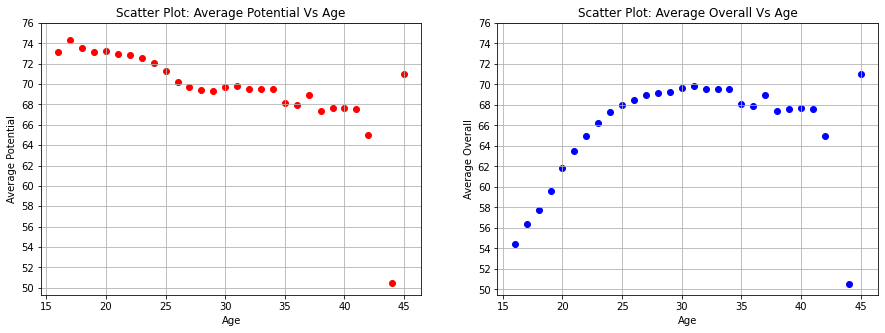

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Your Code for plot
# creating two dataframes that hold Age with Average Potential and Average Overall along with renaming the aggregated columns
df_age_potential = df.groupby('Age').avg('Potential').withColumnRenamed('avg(Potential)', 'Average Potential')
df_age_overall = df.groupby('Age').avg('Overall').withColumnRenamed('avg(Overall)', 'Average Overall')

# first, converting the above two pyspark dataframes to Pandas and storing in a variable
# then, concatenating those two pandas dataframe setting axis 1 i.e. by column
data = [df_age_potential.select('*').toPandas(),df_age_overall.select('Average Overall').toPandas()]
df_age = pd.concat(data, axis=1)
df_age.head(5)

# plotting 
# creating two subplots for plotting Average Potential and Average Overall against Age
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(15,5))
# using first scatter plot for Average Potential and the second for Average Overall 
ax1.scatter(df_age['Age'], df_age['Average Potential'], color='r')
ax2.scatter(df_age['Age'], df_age['Average Overall'], color='b')
# setting y ticks, labels and titles for both plots
ax1.set_yticks(list(range(50,78,2)))
ax2.set_yticks(list(range(50,78,2)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Average Potential')
ax1.set_title('Scatter Plot: Average Potential Vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Average Overall')
ax2.set_title('Scatter Plot: Average Overall Vs Age')
# enabling grid view
ax1.grid(True)
ax2.grid(True)
plt.show()

It is seen from the above scatter plots that average potential decreases with age while average overall increases with age. At age 31, both average potential and average overall meet at the same point (70). So, by the age of 31, players will realise their full potential. After 31, both average potential and average overall declines. However, we can see that at 45 the average poteitial is the highest which can be considered as an outlier.

In [ ]:
# finding the correlation matrix
df_age.corr(method ='pearson') 

,Age,Average Potential,Average Overall
Age,1.000000,-0.703127,0.370369
Average Potential,-0.703127,1.000000,0.199843
Average Overall,0.370369,0.199843,1.000000


The above correlation matrix reflects the same relationship that can be seen in scatter plots.

## Part 2 - Unsupervised Learning: Kmeans




### 2.1 Data Preparation
***

In this stage, we perform clustering of players after grouping them in three groups, DEF, MID and FWD, based on their attributes. So, we remove goalkeepers out from clustering. Later, we analyse what type of positions are mainly included in each cluster.


****

<div class="alert alert-block alert-info">

**Code**: 
    You will need to remove the Goal Keepers (Position = 'GK') and use the position attribute, ID attribute (for later processing) and skill-set attributes (Height(CM),
Weight(KG),
Crossing,
Finishing,
HeadingAccuracy,
ShortPassing,
Volleys,
Dribbling,
Curve,
FKAccuracy,
LongPassing,
BallControl,
Acceleration,
SprintSpeed,
Agility,
Reactions,
Balance,
ShotPower,
Jumping,
Stamina,
Strength,
LongShots,
Aggression,
Interceptions,
Positioning,
Vision,
Penalties,
Composure,
Marking,
StandingTackle,
SlidingTackle) 

</div>



In [ ]:
# Your code to select relevant features and filter the data by removing the GK
# removing the position GK and storing in a new dataframe
df_filtered = df.filter(df['Position'] != 'GK')
# viewing the unique values in the filtered dataframe and check if GK has been removed
df_filtered.select('Position').distinct().show(50)

+--------+
|Position|
+--------+
|      RF|
|     LWB|
|     LCM|
|      LM|
|     RDM|
|      LF|
|     CAM|
|     RAM|
|      LB|
|      LW|
|     RCM|
|      RB|
|      RS|
|     LCB|
|      CM|
|      RW|
|     RCB|
|     CDM|
|      LS|
|      CB|
|     RWB|
|      CF|
|      RM|
|     LAM|
|     LDM|
|      ST|
+--------+



It is seen that GK has been removed and all other positions are present.

To make the later stage easier, we define the position group by using the position feature (attributes on Position).
- DEF = [LB,LWB,RB,LCB,RCB,CB,RWB] ,
- FWD = [RF,LF,LW,RS,RW,LS,CF,ST] ,
- MID = [LCM,LM,RDM,CAM,RAM,RCM,CM,CDM,RM,LAM,LDM]

In [ ]:
from pyspark.sql.functions import when,col

# Your code to complete
# creating a list of specific positions
DEF = ['LB','LWB','RB','LCB','RCB','CB','RWB']
FWD = ['RF','LF','LW','RS','RW','LS','CF','ST']  
MID = ['LCM','LM','RDM','CAM','RAM','RCM','CM','CDM','RM','LAM','LDM'] 

# Your code here to create a new variable df_kmeans_new with a new column Position_Group, ..
# creating a new column which stores values based on conditions
df_kmeans_new = df_filtered.withColumn('Position_Group',F.when(F.col('Position').isin(DEF),'DEF')\
                                  .when(F.col('Position').isin(FWD),'FWD')\
                                  .when(F.col('Position').isin(MID),'MID').otherwise(0))
# checking if correct group has been assigned for specific playing positions
df_kmeans_new.select('Position','Position_Group').distinct().show(50)

+--------+--------------+
|Position|Position_Group|
+--------+--------------+
|     LCB|           DEF|
|      LS|           FWD|
|     RCB|           DEF|
|      ST|           FWD|
|      CF|           FWD|
|     RAM|           MID|
|     RCM|           MID|
|     LCM|           MID|
|      CM|           MID|
|      LF|           FWD|
|      RW|           FWD|
|      LB|           DEF|
|     CDM|           MID|
|     LDM|           MID|
|     RDM|           MID|
|      LM|           MID|
|     LWB|           DEF|
|      RB|           DEF|
|      LW|           FWD|
|      RS|           FWD|
|     LAM|           MID|
|     RWB|           DEF|
|      RM|           MID|
|      CB|           DEF|
|      RF|           FWD|
|     CAM|           MID|
+--------+--------------+



Now, we create a feature vector from different features of a player. We only take the feature vector for clustering purpose removing the Position_Group and Position to create the feature for Kmeans




In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

FEATURES_COL = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
# selecting only ID and features, which is the feature vector in a new dataframe
df_kmeans = vecAssembler.transform(df_kmeans_new).select('ID','features')
df_kmeans.show(3)

+------+--------------------+
|    ID|            features|
+------+--------------------+
|158023|[173.736,72.12112...|
| 20801|[188.976,83.00733...|
|190871|[179.832,68.0388,...|
+------+--------------------+
only showing top 3 rows



Now we plot the elbow plot to determine the optimum number of clusters for our dataset. We test with a range of cluster numbers from 2 to 20.

In [ ]:
# creating an array to store the within  sum of squared errors for different cluster numbers
cost = np.zeros(21)

for k in range(2,21):
# Your code
    # initialising k means with seed value to enable reproducability and fitting the model to df_kmeans
    kmeans_iter = KMeans().setK(k).setSeed(2020)
    model = kmeans_iter.fit(df_kmeans)
    # storing the within sum of squared errors in the cost array
    cost[k] = model.computeCost(df_kmeans)

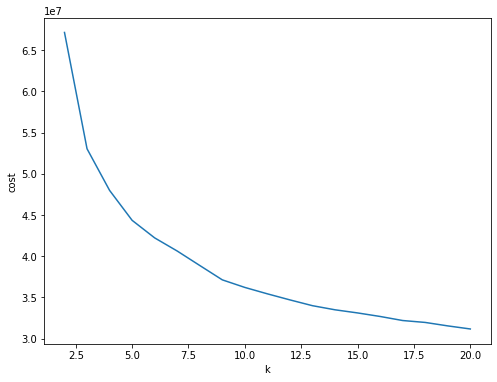

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')

# Your Code
#plotting the within sum of squared errors for each cluster number
ax.plot(range(2,21),cost[2:21])

From the above plot, it can be seen that after k=8 there is not a steep decline in the cost (sum of squared error), so we take k=8 as our elbow point. For clustering, we take 8 as the ideal number of clusters.


### 2.2 K-Means
***



In [ ]:
k = 8

# Your code
kmeans = KMeans().setK(k).setSeed(2020)
model = kmeans.fit(df_kmeans)
# assigning the cluster centers
print('***Cluster Centres***')
cluster_centers = model.clusterCenters()
for i in cluster_centers:
  print(i) # printing the centers

***Cluster Centres***
[177.45568889  77.43733424  55.1521164   69.76785714  66.54365079
  63.61838624  63.81216931  67.9755291   57.9702381   50.59193122
  51.62566138  68.80026455  71.45304233  72.56944444  69.84060847
  66.64484127  64.91005291  71.04034392  71.06547619  68.28835979
  72.6957672   63.88558201  59.07473545  29.97949735  70.10846561
  60.4728836   65.3234127   65.73544974  32.12896825  27.96097884
  24.36904762]
[172.57407959  74.18369877  67.19897959  57.50170068  59.55994898
  72.65008503  56.83418367  69.68707483  66.08886054  61.5454932
  69.27295918  72.10204082  69.22746599  68.61479592  71.1164966
  70.02763605  70.50807823  70.98044218  68.39328231  76.0795068
  68.60416667  65.91411565  70.49532313  67.77380952  64.6420068
  68.03911565  59.26785714  69.40093537  65.37967687  68.28103741
  65.41284014]
[186.0693585   80.24622656  35.22898032  26.64713775  64.65116279
  53.75268336  28.77728086  39.25357782  31.22406082  30.259839
  47.46735242  49.87880143  54

In [ ]:
from pyspark.sql import SQLContext

# Your code
# assigning the unique row to a cluster center while taking off the features column using transform method
predictions = model.transform(df_kmeans).select('ID','prediction')
# assigning the list of predicted ids
predictions_list = predictions.collect()

# instantiating a sqlContext object
sqlContext = SQLContext(spark)
# creating a dataframe using SQLContext object
df_prediction = sqlContext.createDataFrame(predictions_list)
df_prediction.show(10)

+------+----------+
|    ID|prediction|
+------+----------+
|158023|         4|
| 20801|         4|
|190871|         4|
|192985|         1|
|183277|         4|
|177003|         1|
|176580|         4|
|155862|         1|
|188545|         4|
|182521|         1|
+------+----------+
only showing top 10 rows



In [ ]:
# joining the original dataframe containing Position_Group to the prediction dataframe using common column ID
df_prediction_complete = df_prediction.join(df_kmeans_new,'ID')
df_prediction_complete.show()

+------+----------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|prediction|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [ ]:
# counting the position group present in each cluster 
df_prediction_complete.groupby("prediction",'Position_Group').agg(F.count('ID')).sort('prediction').show(30)

+----------+--------------+---------+
|prediction|Position_Group|count(ID)|
+----------+--------------+---------+
|         0|           MID|      255|
|         0|           FWD|     1221|
|         0|           DEF|        1|
|         1|           DEF|      696|
|         1|           MID|     1610|
|         1|           FWD|       51|
|         2|           MID|       70|
|         2|           DEF|     2167|
|         2|           FWD|        1|
|         3|           FWD|     1142|
|         3|           DEF|        1|
|         3|           MID|      108|
|         4|           MID|     1158|
|         4|           DEF|        6|
|         4|           FWD|      471|
|         5|           MID|     1383|
|         5|           FWD|       24|
|         5|           DEF|     1738|
|         6|           FWD|      493|
|         6|           DEF|       17|
|         6|           MID|     1600|
|         7|           DEF|     1240|
|         7|           FWD|       15|
|         7|

## Part 3 - Supervised Learning: Classification on Position_Group


In this part, we try to predict the position group of the player.

### 3.1 Data Preparation

We remove the feature of position and only use the skill set features and the cluster results from Kmeans as the input. The target for classification is "Position_Group".
***

In [ ]:
# renaming the column prediction in our dataframe as Cluster and reflecting the changes in a new dataframe df_kmeans_pred
df_kmeans_pred = df_prediction_complete.withColumnRenamed('prediction', 'Cluster')
df_kmeans_pred.show(5)

+------+-------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|Cluster|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Sk

In [ ]:
# selecting the attributes to get a feature vector later
FEATURES_COL_ = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle','Cluster']


vecAssembler_ = VectorAssembler(inputCols=FEATURES_COL_, outputCol="features")
# this dataframe contains the feature vector generated from players' attributes and their clusters
df_class = vecAssembler_.transform(df_kmeans_pred).select('features','Position_Group')
df_class.show(3)

+--------------------+--------------+
|            features|Position_Group|
+--------------------+--------------+
|[173.736,72.12112...|           FWD|
|[188.976,83.00733...|           FWD|
|[179.832,68.0388,...|           FWD|
+--------------------+--------------+
only showing top 3 rows



Performing feature scaling. For this, we use standard scaling on the features.

In [ ]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(df_class).transform(df_class)
raw_data.select("features","Scaled_features",'Position_Group').show(5)

+--------------------+--------------------+--------------+
|            features|     Scaled_features|Position_Group|
+--------------------+--------------------+--------------+
|[173.736,72.12112...|[12.9261363965246...|           FWD|
|[188.976,83.00733...|[14.0600080102548...|           FWD|
|[179.832,68.0388,...|[13.3796850420166...|           FWD|
|[155.7528,69.8531...|[11.5881678923229...|           MID|
|[176.784,73.93549...|[13.1529107192706...|           FWD|
+--------------------+--------------------+--------------+
only showing top 5 rows



In Spark, we can not use string as Target data type. So, encoding the Position_Group column by using following encoding: 

FWD = 0
DEF = 1
MID = 2

In [ ]:
raw_data_encode = raw_data.withColumn('Target',when(col("Position_Group") == "DEF", 1)
      .when(col("Position_Group")== "FWD", 0)
      .otherwise(2))
raw_data_encode.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[173.736,72.12112...|           FWD|[12.9261363965246...|     0|
|[188.976,83.00733...|           FWD|[14.0600080102548...|     0|
|[179.832,68.0388,...|           FWD|[13.3796850420166...|     0|
|[155.7528,69.8531...|           MID|[11.5881678923229...|     2|
|[176.784,73.93549...|           FWD|[13.1529107192706...|     0|
|[176.784,66.22443...|           MID|[13.1529107192706...|     2|
|[182.88,86.18248,...|           FWD|[13.6064593647627...|     0|
|[182.88,82.100152...|           DEF|[13.6064593647627...|     1|
|[182.88,79.832192...|           FWD|[13.6064593647627...|     0|
|[182.88,76.203456...|           MID|[13.6064593647627...|     2|
|[188.976,78.01782...|           DEF|[14.0600080102548...|     1|
|[176.784,67.13161...|           MID|[13.1529107192706...|     2|
|[170.688,

### 3.2 Training Test Evaluation
***

Splitting the data into train/Test, and evaluating the model performance.

In [ ]:
train, test = raw_data_encode.randomSplit([0.7, 0.3], seed=2020)

In [ ]:
test.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[155.448,58.05977...|           MID|[11.5654904600483...|     2|
|[155.448,62.14210...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           FWD|[11.5654904600483...|     0|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           FWD|[11.5654904600483...|     0|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,64.86365...|           MID|[11.5654904600483...|     2|
|[155.448,64.86365...|           MID|[11.5654904600483...|     2|
|[155.448,

In [ ]:
# using logistic regression for classification
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Target", featuresCol="Scaled_features",maxIter=10)
model=lr.fit(train)

predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Target","prediction").show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       2.0|
|     2|       2.0|
|     2|       2.0|
|     0|       0.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
+------+----------+
only showing top 10 rows



Evaluating the model using confusion matrix.

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
# the label need to be in float datatype otherwise it won't work
# creating a column that represents the target but the datatype is float
predict_test_float = predict_test.select(['prediction','Target']).withColumn('label', F.col('Target').cast(FloatType()))

# selecting only prediction and label columns
predict_test_float = predict_test_float.select(['prediction','label'])
# casting to rdd and mapping to a tuple
metrics = MulticlassMetrics(predict_test_float.rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

array([[ 799.,    2.,  215.],
       [   2., 1442.,  344.],
       [ 174.,  204., 1670.]])

In [ ]:
# changing the confusion matrix array datatype to int as it's datatype is float
confusion_matrix = confusion_matrix.astype('int32')
confusion_matrix

array([[ 799,    2,  215],
       [   2, 1442,  344],
       [ 174,  204, 1670]], dtype=int32)

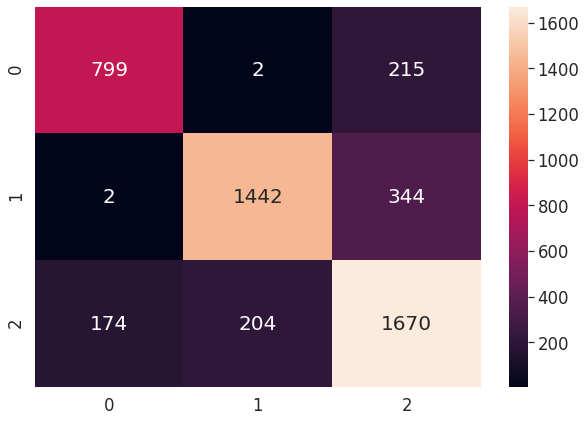

In [ ]:
# creating a heatmap from the confusion matrix
import seaborn as sn 
#creating a dataframe from the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # setting the label size
# drawing the heat map along with displaying values in a digit format and setting the digit size
sn.heatmap(confusion_df, annot=True, fmt='d', annot_kws={"size": 20})


Calculating Precision, Recall and F1 Score.

In [ ]:
for lab in 0.0,1.0,2.0:
  if lab == 0:
    print('Precision for FWD is', metrics.precision(lab))
    print('Recall for FWD is', metrics.recall(lab))
    print('F1-score for FWD is', metrics.fMeasure(lab, beta=1.0))
  elif lab == 1:
    print('Precision for DEF is', metrics.precision(lab))
    print('Recall for DEF is', metrics.recall(lab))
    print('F1-score for DEF is', metrics.fMeasure(lab, beta=1.0))
  else:
    print('Precision for MID is', metrics.precision(lab))
    print('Recall for MID is', metrics.recall(lab))
    print('F1-score for MID is', metrics.fMeasure(lab, beta=1.0))
  print()

Precision for FWD is 0.8194871794871795
Recall for FWD is 0.7864173228346457
F1-score for FWD is 0.802611752887996

Precision for DEF is 0.875
Recall for DEF is 0.8064876957494407
F1-score for DEF is 0.839348079161816

Precision for MID is 0.7492148945715568
Recall for MID is 0.8154296875
F1-score for MID is 0.7809212064531214



### 3.3 K-fold Cross-Validation
***

In this section, we perform hyper-parameter tuning to find the best hyper-parameter set using K-fold cross validation along with param grid. 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Your code 
# We are using Decision Tree as our other classifiers apart from Random Forest classifier and Logistic Regression 
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# building a custom transformer method to encode the position group as done before.
from pyspark.ml import Transformer
from pyspark.sql import DataFrame

# defining a custom transformer to perform label encoding
class LabelEncoder(Transformer):
    """
    A custom Transformer which creates a target column based on the encoding of position group, such as
    if position group is DEF, it is encoded as 1, 0 for FWD and 3 for MID 
    """

    def __init__(self):
        super(LabelEncoder, self).__init__()
        #self.position_group = position_group

    def _transform(self, df: DataFrame) -> DataFrame:
        df = df.withColumn('Target',when(col('Position_Group') == "DEF", 1).when(col('Position_Group')== "FWD", 0)\
      .otherwise(2))
        return df

Preprocessing Stages:

Setting the pipeline

In [ ]:
# creating the preprocessing stages for the Machine Learning pipeline and setting the pipeline
# defining the stage 1
vec_assembler_mlp = VectorAssembler(inputCols=FEATURES_COL_, outputCol="features")
# defining the stage 2
standard_scaler_mlp = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
# defining the stage 3
encoding_mlp = LabelEncoder()
# defining the last stage (random forest)
random_forest = RandomForestClassifier(labelCol='Target', featuresCol='Scaled_features', numTrees=20, maxDepth=5,\
                                       impurity='gini')
# defining the last stage (logistic regression)
logistic_regression = LogisticRegression(featuresCol='Scaled_features', labelCol='Target', maxIter=100, regParam=0, threshold=0.5)
# defining the last stage (decision tree)
decision_tree = DecisionTreeClassifier(featuresCol='Scaled_features', labelCol='Target', maxDepth=5, maxBins=32, impurity='gini')


# setting the pipeline for random_forest
pipeline_random_forest = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, random_forest])
# setting the pipeline for logistic_regression
pipeline_logistic_regression = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, logistic_regression])
# setting the pipeline for decision tree
pipeline_decision_tree = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, decision_tree])

Buidling parameter grids

In [ ]:
# building a grid of parameters for random forest to be used by the cross-
# providing number of trees, depth of trees and impurity measures as inputs for parameter grids
paramGrid_random_forest = ParamGridBuilder().addGrid(random_forest.numTrees, [5, 10, 20, 40])\
.addGrid(random_forest.maxDepth, [4,14,24])\
.addGrid(random_forest.impurity, ['entropy', 'gini']).build()

# building a grid of parameters for logistic regression to be used by the cross-validation
# providing iteration number, different lambda values and threshold values for paramter grids
paramGrid_logistic_regression = ParamGridBuilder().addGrid(logistic_regression.maxIter, [50, 100, 200, 250])\
.addGrid(logistic_regression.regParam, [0.1,0, 1, 10]).build()

# building a grid of parameters for decision tree to be used by the cross-validation
# providing various maxBins, maxDepth and impurity values as parameters
paramGrid_decision_tree = ParamGridBuilder().addGrid(decision_tree.maxDepth, [5, 10, 20, 30])\
 .addGrid(decision_tree.maxBins, [15, 25, 32])\
 .addGrid(decision_tree.impurity, ['entropy', 'gini']).build()

Splitting the dataset

In [ ]:
# splitting the data into training and testing dataset
training, testing = df_kmeans_pred.randomSplit([0.7, 0.3], seed=12)

**Cross validation**




Cross validating the random forest

In [ ]:
# cross validating for random forest
crossval_random_forest = CrossValidator(estimator=pipeline_random_forest,\
                          estimatorParamMaps=paramGrid_random_forest,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)

# fitting the training data
cv_random_forest= crossval_random_forest.fit(training)

Displaying the parameter values with scores along with finding the best parameter values and fitting the testing dataset

In [ ]:
# creating a dictionary of parameter and values after retrieving the estimator parameter map
parameter_values_rf = [{parameter.name: values for parameter, values in parameter_maps.items()} for parameter_maps in cv_random_forest.getEstimatorParamMaps()]
#print(parameter_values_rf)
# creating a pandas dataframe containing measuring scores corresponding to each parameter value for different parameters from a dictionary 
# the first column is the score and the remaining are the parameters
pd.DataFrame.from_dict([{cv_random_forest.getEvaluator().getMetricName(): metric, **pvs}\
    for pvs, metric in zip(parameter_values_rf, cv_random_forest.avgMetrics)
])

,f1,numTrees,maxDepth,impurity
0,0.791475,5,4,entropy
1,0.792626,5,4,gini
2,0.837618,5,14,entropy
3,0.826635,5,14,gini
4,0.834765,5,24,entropy
5,0.819461,5,24,gini
6,0.800359,10,4,entropy
7,0.804420,10,4,gini
8,0.850241,10,14,entropy
9,0.844617,10,14,gini


In [ ]:
# printing the parameter values for the best estimator
print(cv_random_forest.getEstimatorParamMaps()[np.argmax(cv_random_forest.avgMetrics)])

{Param(parent='RandomForestClassifier_3317a8266669', name='numTrees', doc='Number of trees to train (>= 1).'): 40, Param(parent='RandomForestClassifier_3317a8266669', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 14, Param(parent='RandomForestClassifier_3317a8266669', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy'}


In [ ]:
# fitting the training data using the best model
prediction_random_forest = cv_random_forest.bestModel.transform(testing).select('Target', 'prediction')
prediction_random_forest.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



Cross validating the logistic regression

In [ ]:
# cross validating for logistic regression
crossval_logistic_regression = CrossValidator(estimator=pipeline_logistic_regression,\
                          estimatorParamMaps=paramGrid_logistic_regression,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)

# fitting the training dataset
cv_logistic_regression = crossval_logistic_regression.fit(training)

Displaying the parameter values with scores along with finding the best parameter values and fitting the testing dataset

In [ ]:
# creating a dictionary of parameter and values after retrieving the estimator parameter map
parameter_values_lr = [{parameter.name: values for parameter, values in parameter_maps.items()} for parameter_maps in cv_logistic_regression.getEstimatorParamMaps()]
# creating a pandas dataframe containing measuring scores corresponding to each parameter value for different parameters from a dictionary 
# the first column is the score and the remaining are the parameters
pd.DataFrame.from_dict([{cv_logistic_regression.getEvaluator().getMetricName(): metric, **pvs}\
    for pvs, metric in zip(parameter_values_lr, cv_logistic_regression.avgMetrics)
])

,f1,maxIter,regParam
0,0.845919,50,0.1
1,0.862929,50,0.0
2,0.796646,50,1.0
3,0.565956,50,10.0
4,0.845734,100,0.1
5,0.863157,100,0.0
6,0.796196,100,1.0
7,0.565956,100,10.0
8,0.845825,200,0.1
9,0.863415,200,0.0


In [ ]:
# printing the parameter values for the best estimator
print(cv_logistic_regression.getEstimatorParamMaps()[np.argmax(cv_logistic_regression.avgMetrics)])

{Param(parent='LogisticRegression_e1db64c2a71b', name='maxIter', doc='max number of iterations (>= 0).'): 250, Param(parent='LogisticRegression_e1db64c2a71b', name='regParam', doc='regularization parameter (>= 0).'): 0.0}


In [ ]:
# fitting the training data using the best model
prediction_logistic_regression = cv_logistic_regression.bestModel.transform(testing).select('Target', 'prediction')
prediction_logistic_regression.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



Cross validating the Decision Tree

In [ ]:
# cross validating for decision tree
crossval_decision_tree = CrossValidator(estimator=pipeline_decision_tree,\
                          estimatorParamMaps=paramGrid_decision_tree,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction'),\
                          numFolds=10)
# fitting the training dataset
cv_decision_tree = crossval_decision_tree.fit(training)

Displaying the parameter values with scores along with finding the best parameter values and fitting the testing dataset

In [ ]:
# creating a dictionary of parameter and values after retrieving the estimator parameter map
parameter_values_nb = [{parameter.name: values for parameter, values in parameter_maps.items()} for parameter_maps in cv_decision_tree.getEstimatorParamMaps()]
# creating a pandas dataframe containing measuring scores corresponding to each parameter value for different parameters from a dictionary 
# the first column is the score and the remaining are the parameters
pd.DataFrame.from_dict([{cv_decision_tree.getEvaluator().getMetricName(): metric, **pvs}\
    for pvs, metric in zip(parameter_values_nb, cv_decision_tree.avgMetrics)
])

,f1,maxDepth,maxBins,impurity
0,0.804606,5,15,entropy
1,0.805201,5,15,gini
2,0.805719,5,25,entropy
3,0.809651,5,25,gini
4,0.803783,5,32,entropy
5,0.805239,5,32,gini
6,0.816663,10,15,entropy
7,0.814264,10,15,gini
8,0.809764,10,25,entropy
9,0.819418,10,25,gini


In [ ]:
# printing the parameter values for the best estimator
print(cv_decision_tree.getEstimatorParamMaps()[np.argmax(cv_decision_tree.avgMetrics)])

{Param(parent='DecisionTreeClassifier_0c689782ce86', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='DecisionTreeClassifier_0c689782ce86', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 25, Param(parent='DecisionTreeClassifier_0c689782ce86', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}


In [ ]:
# fitting the training data using the best model
prediction_decision_tree = cv_decision_tree.bestModel.transform(testing).select('Target', 'prediction')
prediction_decision_tree.show()

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       1.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



Further Analysis